In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

In [3]:
#encoding: utf-8
import gym
import random
import os
import numpy as np
from collections      import deque
from keras.models     import Sequential
from keras.layers     import Dense
from keras.optimizers import Adam
from keras import callbacks

Using TensorFlow backend.


In [4]:
import time

In [5]:
def moving_average(a, n=100) :
    ret = np.cumsum(a, dtype=int)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [6]:
class QNetwork:
    def __init__(self, is_load_weights=False, learning_rate=0.01, state_size=4,
                 action_size=2, hidden_size=24, model_name="cartpole-ddqn"):
        self.backup_path = "./" + model_name + ".h5"
        
        # state inputs to the Q-network
        self.model = Sequential()

        self.model.add(Dense(hidden_size, activation='relu',
                             input_dim=state_size))
        self.model.add(Dense(hidden_size, activation='relu'))
        self.model.add(Dense(action_size, activation='linear'))

        self.optimizer = Adam(lr=learning_rate)
        self.model.compile(loss='mse', optimizer=self.optimizer)
        if (is_load_weights):
            print("load model weights from " + self.backup_path)
            if os.path.isfile(self.backup_path):
                self.model.load_weights(self.backup_path)
                print("Done")
                # self.exploration_rate = self.exploration_min
            else:
                print("Fail")
        
    def save_model(self):
        print("save model weights to " + self.backup_path)
        self.model.save(self.backup_path)


In [7]:
class Memory():
    def __init__(self, max_size=2000):
        self.buffer = deque(maxlen=max_size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)),
                               size=batch_size,
                               replace=False)
        return [self.buffer[ii] for ii in idx]      

In [8]:
class Agent():
    def __init__(self, state_size, action_size, model):
        self.model              = model
        self.state_size         = state_size
        self.action_size        = action_size
        self.exploration_rate   = 1.0
        self.exploration_min    = 0.01
        self.exploration_decay  = 0.99

    def act(self, state):
        if np.random.rand() <= self.exploration_rate:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])
    
    def modify_exploration_rate(self):
        if self.exploration_rate > self.exploration_min:
            self.exploration_rate *= self.exploration_decay
        # print("exploration_rate=", self.exploration_rate)


In [9]:
class CartPole:
    def __init__(self, episodes=1000):
        self.model_name         = "cartpole_ddqn_v0"
        self.sample_batch_size  = 32
        self.episodes           = episodes
        self.gamma              = 0.99
        self.env                = gym.make('CartPole-v0')
        self.state_size         = self.env.observation_space.shape[0]
        self.action_size        = self.env.action_space.n
        self.memory             = Memory(max_size=1000)
        self.network            = QNetwork(is_load_weights=False, state_size=self.state_size, action_size=self.action_size, 
                                           hidden_size=16, learning_rate=0.001, model_name=self.model_name)
        # DDQN
        self.target_network      = QNetwork(is_load_weights=False, state_size=self.state_size, action_size=self.action_size, 
                                           hidden_size=16, learning_rate=0.001, model_name=self.model_name)
       
        self.agent              = Agent(self.state_size, self.action_size, self.network.model)
        tensorboard_path = "./TensorBoard/" + self.model_name
        self.tboard_callback = callbacks.TensorBoard(log_dir=tensorboard_path, histogram_freq=0, write_graph=True, write_images=True)
        self.env.seed(13)
        self.save_model = True
        

    def run(self, isRender=False):
        scores = []
        start = time.time()
        print('Experiment start at ', time.ctime())
        try:
            for index_episode in range(self.episodes):
                state = self.env.reset()
                state = np.reshape(state, [1, self.state_size])

                done = False
                index = 0
                while not done:
                    if isRender:
                        self.env.render()
                    action = self.agent.act(state)
                    next_state, reward, done, _ = self.env.step(action)
                    if done:
                        reward = -1
                        self.memory.add((state, action, reward, None, done))
                    else:
                        next_state = np.reshape(next_state, [1, self.state_size])
                        self.memory.add((state, action, reward, next_state, done))
                        state = next_state
                    index += 1
                print("Episode {}# Score: {}".format(index_episode, index))
                scores.append(index)
                if len(self.memory.buffer) >= self.sample_batch_size:
                    self.train_network()
                    self.agent.modify_exploration_rate()
                    self.update_target_model()
        finally:
            end = time.time()
            print('Experiment end at ', time.ctime())
            print('Time consumed ', end - start)
            if self.save_model:
                self.network.save_model()

        return scores
            
    def train_network(self):
        sample_batch = self.memory.sample(self.sample_batch_size)
        model = self.network.model
        target_model = self.target_network.model
        for state, action, reward, next_state, done in sample_batch:
            if done:
                target = reward
            else:
                target = reward + self.gamma * np.amax(target_model.predict(next_state)[0])
            target_f = model.predict(state)
            target_f[0][action] = target
            # model.fit(state, target_f, epochs=1, verbose=0, callbacks=[self.tboard_callback])
            model.fit(state, target_f, epochs=1, verbose=0)

    def update_target_model(self):
        # copy weights from q-model to target_model
        self.target_network.model.set_weights(self.network.model.get_weights())

/home/ubuntu/miniconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Experiment start at  Tue Jan  8 14:53:53 2019
Episode 0# Score: 15
Episode 1# Score: 17
Episode 2# Score: 15
Episode 3# Score: 18
Episode 4# Score: 13
Episode 5# Score: 16
Episode 6# Score: 45
Episode 7# Score: 19
Episode 8# Score: 14
Episode 9# Score: 20
Episode 10# Score: 16
Episode 11# Score: 17
Episode 12# Score: 11
Episode 13# Score: 21
Episode 14# Score: 10
Episode 15# Score: 11
Episode 16# Score: 13
Episode 17# Score: 13
Episode 18# Score: 27
Episode 19# Score: 10
Episode 20# Score: 14
Episode 21# Score: 17
Episode 22# Score: 28
Episode 23# Score: 10
Episode 24# Score: 11
Episode 25# Score: 23
Episode 26# Score: 24
Episode 27# Score: 17
Episode 28# Score: 11
Episode 29# Score: 18
Episode 30# Score: 16
Episode 31# Score: 25
Episode 32# Score: 20
Episode 33# Score: 10
Episode 34# Score: 11
Episode 35# Score: 15
Episode 36# Score: 10
Episode 37# Score: 15
Episode 38# Score: 16
Episode 39# Score: 14
Episode 40# Score: 19
Episode 41# Score: 13
Episode 42# Score: 19
Episode 43# Score:

Episode 359# Score: 48
Episode 360# Score: 83
Episode 361# Score: 50
Episode 362# Score: 52
Episode 363# Score: 44
Episode 364# Score: 39
Episode 365# Score: 53
Episode 366# Score: 55
Episode 367# Score: 55
Episode 368# Score: 37
Episode 369# Score: 33
Episode 370# Score: 29
Episode 371# Score: 40
Episode 372# Score: 29
Episode 373# Score: 26
Episode 374# Score: 21
Episode 375# Score: 43
Episode 376# Score: 45
Episode 377# Score: 36
Episode 378# Score: 26
Episode 379# Score: 22
Episode 380# Score: 27
Episode 381# Score: 34
Episode 382# Score: 23
Episode 383# Score: 46
Episode 384# Score: 64
Episode 385# Score: 55
Episode 386# Score: 49
Episode 387# Score: 89
Episode 388# Score: 56
Episode 389# Score: 40
Episode 390# Score: 36
Episode 391# Score: 78
Episode 392# Score: 140
Episode 393# Score: 31
Episode 394# Score: 70
Episode 395# Score: 14
Episode 396# Score: 14
Episode 397# Score: 53
Episode 398# Score: 44
Episode 399# Score: 30
Episode 400# Score: 15
Episode 401# Score: 88
Episode 40

Episode 708# Score: 135
Episode 709# Score: 142
Episode 710# Score: 112
Episode 711# Score: 26
Episode 712# Score: 89
Episode 713# Score: 110
Episode 714# Score: 98
Episode 715# Score: 92
Episode 716# Score: 98
Episode 717# Score: 107
Episode 718# Score: 114
Episode 719# Score: 99
Episode 720# Score: 111
Episode 721# Score: 114
Episode 722# Score: 90
Episode 723# Score: 105
Episode 724# Score: 98
Episode 725# Score: 104
Episode 726# Score: 146
Episode 727# Score: 112
Episode 728# Score: 103
Episode 729# Score: 102
Episode 730# Score: 115
Episode 731# Score: 102
Episode 732# Score: 131
Episode 733# Score: 123
Episode 734# Score: 106
Episode 735# Score: 106
Episode 736# Score: 103
Episode 737# Score: 122
Episode 738# Score: 113
Episode 739# Score: 124
Episode 740# Score: 121
Episode 741# Score: 136
Episode 742# Score: 127
Episode 743# Score: 125
Episode 744# Score: 120
Episode 745# Score: 129
Episode 746# Score: 128
Episode 747# Score: 122
Episode 748# Score: 133
Episode 749# Score: 129


Episode 1051# Score: 161
Episode 1052# Score: 200
Episode 1053# Score: 173
Episode 1054# Score: 171
Episode 1055# Score: 183
Episode 1056# Score: 171
Episode 1057# Score: 158
Episode 1058# Score: 174
Episode 1059# Score: 183
Episode 1060# Score: 160
Episode 1061# Score: 187
Episode 1062# Score: 154
Episode 1063# Score: 155
Episode 1064# Score: 200
Episode 1065# Score: 200
Episode 1066# Score: 161
Episode 1067# Score: 150
Episode 1068# Score: 200
Episode 1069# Score: 176
Episode 1070# Score: 161
Episode 1071# Score: 190
Episode 1072# Score: 200
Episode 1073# Score: 182
Episode 1074# Score: 200
Episode 1075# Score: 200
Episode 1076# Score: 151
Episode 1077# Score: 200
Episode 1078# Score: 171
Episode 1079# Score: 167
Episode 1080# Score: 200
Episode 1081# Score: 170
Episode 1082# Score: 158
Episode 1083# Score: 200
Episode 1084# Score: 189
Episode 1085# Score: 200
Episode 1086# Score: 200
Episode 1087# Score: 183
Episode 1088# Score: 15
Episode 1089# Score: 38
Episode 1090# Score: 200
Ep

Episode 1380# Score: 200
Episode 1381# Score: 122
Episode 1382# Score: 174
Episode 1383# Score: 174
Episode 1384# Score: 177
Episode 1385# Score: 162
Episode 1386# Score: 122
Episode 1387# Score: 151
Episode 1388# Score: 177
Episode 1389# Score: 149
Episode 1390# Score: 167
Episode 1391# Score: 200
Episode 1392# Score: 161
Episode 1393# Score: 200
Episode 1394# Score: 114
Episode 1395# Score: 134
Episode 1396# Score: 138
Episode 1397# Score: 171
Episode 1398# Score: 149
Episode 1399# Score: 173
Episode 1400# Score: 151
Episode 1401# Score: 196
Episode 1402# Score: 200
Episode 1403# Score: 10
Episode 1404# Score: 200
Episode 1405# Score: 164
Episode 1406# Score: 200
Episode 1407# Score: 200
Episode 1408# Score: 13
Episode 1409# Score: 106
Episode 1410# Score: 192
Episode 1411# Score: 125
Episode 1412# Score: 134
Episode 1413# Score: 121
Episode 1414# Score: 99
Episode 1415# Score: 99
Episode 1416# Score: 110
Episode 1417# Score: 108
Episode 1418# Score: 114
Episode 1419# Score: 110
Epis

Episode 1709# Score: 130
Episode 1710# Score: 200
Episode 1711# Score: 122
Episode 1712# Score: 200
Episode 1713# Score: 170
Episode 1714# Score: 146
Episode 1715# Score: 14
Episode 1716# Score: 54
Episode 1717# Score: 154
Episode 1718# Score: 137
Episode 1719# Score: 152
Episode 1720# Score: 132
Episode 1721# Score: 136
Episode 1722# Score: 142
Episode 1723# Score: 200
Episode 1724# Score: 183
Episode 1725# Score: 141
Episode 1726# Score: 155
Episode 1727# Score: 125
Episode 1728# Score: 118
Episode 1729# Score: 129
Episode 1730# Score: 142
Episode 1731# Score: 138
Episode 1732# Score: 140
Episode 1733# Score: 179
Episode 1734# Score: 142
Episode 1735# Score: 181
Episode 1736# Score: 121
Episode 1737# Score: 157
Episode 1738# Score: 117
Episode 1739# Score: 123
Episode 1740# Score: 200
Episode 1741# Score: 117
Episode 1742# Score: 200
Episode 1743# Score: 200
Episode 1744# Score: 158
Episode 1745# Score: 170
Episode 1746# Score: 178
Episode 1747# Score: 175
Episode 1748# Score: 125
Ep

Episode 2038# Score: 200
Episode 2039# Score: 200
Episode 2040# Score: 150
Episode 2041# Score: 172
Episode 2042# Score: 200
Episode 2043# Score: 194
Episode 2044# Score: 167
Episode 2045# Score: 200
Episode 2046# Score: 200
Episode 2047# Score: 175
Episode 2048# Score: 179
Episode 2049# Score: 163
Episode 2050# Score: 197
Episode 2051# Score: 200
Episode 2052# Score: 200
Episode 2053# Score: 151
Episode 2054# Score: 200
Episode 2055# Score: 177
Episode 2056# Score: 186
Episode 2057# Score: 177
Episode 2058# Score: 200
Episode 2059# Score: 173
Episode 2060# Score: 200
Episode 2061# Score: 200
Episode 2062# Score: 186
Episode 2063# Score: 200
Episode 2064# Score: 200
Episode 2065# Score: 200
Episode 2066# Score: 110
Episode 2067# Score: 198
Episode 2068# Score: 200
Episode 2069# Score: 182
Episode 2070# Score: 180
Episode 2071# Score: 200
Episode 2072# Score: 200
Episode 2073# Score: 200
Episode 2074# Score: 200
Episode 2075# Score: 200
Episode 2076# Score: 200
Episode 2077# Score: 200


Episode 2367# Score: 153
Episode 2368# Score: 166
Episode 2369# Score: 199
Episode 2370# Score: 146
Episode 2371# Score: 193
Episode 2372# Score: 167
Episode 2373# Score: 147
Episode 2374# Score: 176
Episode 2375# Score: 158
Episode 2376# Score: 164
Episode 2377# Score: 172
Episode 2378# Score: 157
Episode 2379# Score: 154
Episode 2380# Score: 167
Episode 2381# Score: 200
Episode 2382# Score: 165
Episode 2383# Score: 200
Episode 2384# Score: 200
Episode 2385# Score: 193
Episode 2386# Score: 200
Episode 2387# Score: 200
Episode 2388# Score: 195
Episode 2389# Score: 200
Episode 2390# Score: 200
Episode 2391# Score: 200
Episode 2392# Score: 200
Episode 2393# Score: 193
Episode 2394# Score: 199
Episode 2395# Score: 183
Episode 2396# Score: 200
Episode 2397# Score: 200
Episode 2398# Score: 153
Episode 2399# Score: 200
Episode 2400# Score: 157
Episode 2401# Score: 179
Episode 2402# Score: 154
Episode 2403# Score: 170
Episode 2404# Score: 200
Episode 2405# Score: 175
Episode 2406# Score: 199


Episode 2696# Score: 200
Episode 2697# Score: 190
Episode 2698# Score: 200
Episode 2699# Score: 191
Episode 2700# Score: 200
Episode 2701# Score: 176
Episode 2702# Score: 200
Episode 2703# Score: 200
Episode 2704# Score: 200
Episode 2705# Score: 200
Episode 2706# Score: 200
Episode 2707# Score: 200
Episode 2708# Score: 200
Episode 2709# Score: 200
Episode 2710# Score: 200
Episode 2711# Score: 200
Episode 2712# Score: 79
Episode 2713# Score: 200
Episode 2714# Score: 198
Episode 2715# Score: 200
Episode 2716# Score: 200
Episode 2717# Score: 200
Episode 2718# Score: 192
Episode 2719# Score: 168
Episode 2720# Score: 200
Episode 2721# Score: 200
Episode 2722# Score: 200
Episode 2723# Score: 200
Episode 2724# Score: 200
Episode 2725# Score: 200
Episode 2726# Score: 200
Episode 2727# Score: 200
Episode 2728# Score: 200
Episode 2729# Score: 200
Episode 2730# Score: 200
Episode 2731# Score: 200
Episode 2732# Score: 200
Episode 2733# Score: 200
Episode 2734# Score: 200
Episode 2735# Score: 200
E

Episode 3025# Score: 200
Episode 3026# Score: 200
Episode 3027# Score: 200
Episode 3028# Score: 200
Episode 3029# Score: 200
Episode 3030# Score: 200
Episode 3031# Score: 200
Episode 3032# Score: 200
Episode 3033# Score: 200
Episode 3034# Score: 200
Episode 3035# Score: 200
Episode 3036# Score: 200
Episode 3037# Score: 200
Episode 3038# Score: 200
Episode 3039# Score: 200
Episode 3040# Score: 200
Episode 3041# Score: 200
Episode 3042# Score: 200
Episode 3043# Score: 16
Episode 3044# Score: 200
Episode 3045# Score: 200
Episode 3046# Score: 200
Episode 3047# Score: 200
Episode 3048# Score: 200
Episode 3049# Score: 200
Episode 3050# Score: 200
Episode 3051# Score: 200
Episode 3052# Score: 200
Episode 3053# Score: 200
Episode 3054# Score: 200
Episode 3055# Score: 200
Episode 3056# Score: 200
Episode 3057# Score: 200
Episode 3058# Score: 197
Episode 3059# Score: 200
Episode 3060# Score: 200
Episode 3061# Score: 200
Episode 3062# Score: 200
Episode 3063# Score: 191
Episode 3064# Score: 200
E

Episode 3354# Score: 200
Episode 3355# Score: 200
Episode 3356# Score: 200
Episode 3357# Score: 200
Episode 3358# Score: 200
Episode 3359# Score: 200
Episode 3360# Score: 200
Episode 3361# Score: 200
Episode 3362# Score: 200
Episode 3363# Score: 200
Episode 3364# Score: 200
Episode 3365# Score: 200
Episode 3366# Score: 200
Episode 3367# Score: 49
Episode 3368# Score: 147
Episode 3369# Score: 200
Episode 3370# Score: 200
Episode 3371# Score: 200
Episode 3372# Score: 200
Episode 3373# Score: 200
Episode 3374# Score: 200
Episode 3375# Score: 200
Episode 3376# Score: 200
Episode 3377# Score: 200
Episode 3378# Score: 200
Episode 3379# Score: 200
Episode 3380# Score: 200
Episode 3381# Score: 200
Episode 3382# Score: 200
Episode 3383# Score: 200
Episode 3384# Score: 200
Episode 3385# Score: 200
Episode 3386# Score: 193
Episode 3387# Score: 200
Episode 3388# Score: 200
Episode 3389# Score: 200
Episode 3390# Score: 200
Episode 3391# Score: 200
Episode 3392# Score: 200
Episode 3393# Score: 200
E

Episode 3685# Score: 177
Episode 3686# Score: 62
Episode 3687# Score: 67
Episode 3688# Score: 53
Episode 3689# Score: 57
Episode 3690# Score: 85
Episode 3691# Score: 61
Episode 3692# Score: 200
Episode 3693# Score: 200
Episode 3694# Score: 89
Episode 3695# Score: 174
Episode 3696# Score: 118
Episode 3697# Score: 82
Episode 3698# Score: 62
Episode 3699# Score: 112
Episode 3700# Score: 200
Episode 3701# Score: 93
Episode 3702# Score: 96
Episode 3703# Score: 79
Episode 3704# Score: 100
Episode 3705# Score: 200
Episode 3706# Score: 74
Episode 3707# Score: 83
Episode 3708# Score: 186
Episode 3709# Score: 76
Episode 3710# Score: 200
Episode 3711# Score: 200
Episode 3712# Score: 94
Episode 3713# Score: 90
Episode 3714# Score: 200
Episode 3715# Score: 82
Episode 3716# Score: 47
Episode 3717# Score: 200
Episode 3718# Score: 107
Episode 3719# Score: 93
Episode 3720# Score: 72
Episode 3721# Score: 67
Episode 3722# Score: 139
Episode 3723# Score: 70
Episode 3724# Score: 71
Episode 3725# Score: 80


Episode 4015# Score: 200
Episode 4016# Score: 200
Episode 4017# Score: 200
Episode 4018# Score: 200
Episode 4019# Score: 200
Episode 4020# Score: 200
Episode 4021# Score: 200
Episode 4022# Score: 137
Episode 4023# Score: 168
Episode 4024# Score: 158
Episode 4025# Score: 165
Episode 4026# Score: 200
Episode 4027# Score: 169
Episode 4028# Score: 200
Episode 4029# Score: 200
Episode 4030# Score: 200
Episode 4031# Score: 180
Episode 4032# Score: 200
Episode 4033# Score: 200
Episode 4034# Score: 200
Episode 4035# Score: 128
Episode 4036# Score: 200
Episode 4037# Score: 200
Episode 4038# Score: 176
Episode 4039# Score: 121
Episode 4040# Score: 198
Episode 4041# Score: 185
Episode 4042# Score: 140
Episode 4043# Score: 163
Episode 4044# Score: 197
Episode 4045# Score: 200
Episode 4046# Score: 150
Episode 4047# Score: 200
Episode 4048# Score: 200
Episode 4049# Score: 161
Episode 4050# Score: 141
Episode 4051# Score: 200
Episode 4052# Score: 200
Episode 4053# Score: 200
Episode 4054# Score: 200


Episode 4343# Score: 200
Episode 4344# Score: 200
Episode 4345# Score: 200
Episode 4346# Score: 200
Episode 4347# Score: 200
Episode 4348# Score: 200
Episode 4349# Score: 200
Episode 4350# Score: 200
Episode 4351# Score: 200
Episode 4352# Score: 200
Episode 4353# Score: 200
Episode 4354# Score: 200
Episode 4355# Score: 200
Episode 4356# Score: 162
Episode 4357# Score: 197
Episode 4358# Score: 185
Episode 4359# Score: 200
Episode 4360# Score: 200
Episode 4361# Score: 200
Episode 4362# Score: 200
Episode 4363# Score: 200
Episode 4364# Score: 173
Episode 4365# Score: 195
Episode 4366# Score: 197
Episode 4367# Score: 200
Episode 4368# Score: 155
Episode 4369# Score: 169
Episode 4370# Score: 200
Episode 4371# Score: 200
Episode 4372# Score: 171
Episode 4373# Score: 177
Episode 4374# Score: 200
Episode 4375# Score: 200
Episode 4376# Score: 200
Episode 4377# Score: 200
Episode 4378# Score: 200
Episode 4379# Score: 158
Episode 4380# Score: 200
Episode 4381# Score: 200
Episode 4382# Score: 200


Episode 4672# Score: 200
Episode 4673# Score: 200
Episode 4674# Score: 200
Episode 4675# Score: 200
Episode 4676# Score: 200
Episode 4677# Score: 200
Episode 4678# Score: 200
Episode 4679# Score: 200
Episode 4680# Score: 200
Episode 4681# Score: 200
Episode 4682# Score: 200
Episode 4683# Score: 200
Episode 4684# Score: 200
Episode 4685# Score: 200
Episode 4686# Score: 200
Episode 4687# Score: 200
Episode 4688# Score: 200
Episode 4689# Score: 200
Episode 4690# Score: 200
Episode 4691# Score: 200
Episode 4692# Score: 200
Episode 4693# Score: 200
Episode 4694# Score: 200
Episode 4695# Score: 199
Episode 4696# Score: 200
Episode 4697# Score: 200
Episode 4698# Score: 200
Episode 4699# Score: 200
Episode 4700# Score: 200
Episode 4701# Score: 200
Episode 4702# Score: 200
Episode 4703# Score: 200
Episode 4704# Score: 180
Episode 4705# Score: 200
Episode 4706# Score: 200
Episode 4707# Score: 200
Episode 4708# Score: 200
Episode 4709# Score: 200
Episode 4710# Score: 200
Episode 4711# Score: 200


Episode 5000# Score: 200
Episode 5001# Score: 200
Episode 5002# Score: 200
Episode 5003# Score: 200
Episode 5004# Score: 200
Episode 5005# Score: 200
Episode 5006# Score: 200
Episode 5007# Score: 200
Episode 5008# Score: 200
Episode 5009# Score: 200
Episode 5010# Score: 200
Episode 5011# Score: 200
Episode 5012# Score: 200
Episode 5013# Score: 149
Episode 5014# Score: 191
Episode 5015# Score: 200
Episode 5016# Score: 196
Episode 5017# Score: 200
Episode 5018# Score: 200
Episode 5019# Score: 200
Episode 5020# Score: 200
Episode 5021# Score: 156
Episode 5022# Score: 200
Episode 5023# Score: 200
Episode 5024# Score: 200
Episode 5025# Score: 200
Episode 5026# Score: 200
Episode 5027# Score: 200
Episode 5028# Score: 200
Episode 5029# Score: 200
Episode 5030# Score: 200
Episode 5031# Score: 200
Episode 5032# Score: 200
Episode 5033# Score: 200
Episode 5034# Score: 152
Episode 5035# Score: 166
Episode 5036# Score: 200
Episode 5037# Score: 200
Episode 5038# Score: 200
Episode 5039# Score: 200


Episode 5329# Score: 200
Episode 5330# Score: 200
Episode 5331# Score: 200
Episode 5332# Score: 200
Episode 5333# Score: 200
Episode 5334# Score: 200
Episode 5335# Score: 200
Episode 5336# Score: 200
Episode 5337# Score: 200
Episode 5338# Score: 200
Episode 5339# Score: 168
Episode 5340# Score: 200
Episode 5341# Score: 200
Episode 5342# Score: 200
Episode 5343# Score: 163
Episode 5344# Score: 200
Episode 5345# Score: 200
Episode 5346# Score: 176
Episode 5347# Score: 200
Episode 5348# Score: 164
Episode 5349# Score: 200
Episode 5350# Score: 200
Episode 5351# Score: 200
Episode 5352# Score: 200
Episode 5353# Score: 200
Episode 5354# Score: 200
Episode 5355# Score: 200
Episode 5356# Score: 200
Episode 5357# Score: 200
Episode 5358# Score: 190
Episode 5359# Score: 200
Episode 5360# Score: 200
Episode 5361# Score: 200
Episode 5362# Score: 148
Episode 5363# Score: 135
Episode 5364# Score: 170
Episode 5365# Score: 168
Episode 5366# Score: 178
Episode 5367# Score: 200
Episode 5368# Score: 164


Episode 5657# Score: 178
Episode 5658# Score: 200
Episode 5659# Score: 200
Episode 5660# Score: 152
Episode 5661# Score: 128
Episode 5662# Score: 200
Episode 5663# Score: 200
Episode 5664# Score: 200
Episode 5665# Score: 200
Episode 5666# Score: 200
Episode 5667# Score: 200
Episode 5668# Score: 200
Episode 5669# Score: 200
Episode 5670# Score: 200
Episode 5671# Score: 200
Episode 5672# Score: 140
Episode 5673# Score: 200
Episode 5674# Score: 200
Episode 5675# Score: 200
Episode 5676# Score: 200
Episode 5677# Score: 200
Episode 5678# Score: 200
Episode 5679# Score: 200
Episode 5680# Score: 200
Episode 5681# Score: 200
Episode 5682# Score: 200
Episode 5683# Score: 200
Episode 5684# Score: 200
Episode 5685# Score: 200
Episode 5686# Score: 200
Episode 5687# Score: 200
Episode 5688# Score: 200
Episode 5689# Score: 200
Episode 5690# Score: 146
Episode 5691# Score: 153
Episode 5692# Score: 89
Episode 5693# Score: 155
Episode 5694# Score: 162
Episode 5695# Score: 132
Episode 5696# Score: 150
E

Episode 5986# Score: 200
Episode 5987# Score: 200
Episode 5988# Score: 200
Episode 5989# Score: 200
Episode 5990# Score: 200
Episode 5991# Score: 200
Episode 5992# Score: 200
Episode 5993# Score: 200
Episode 5994# Score: 200
Episode 5995# Score: 200
Episode 5996# Score: 200
Episode 5997# Score: 200
Episode 5998# Score: 200
Episode 5999# Score: 200
Episode 6000# Score: 200
Episode 6001# Score: 200
Episode 6002# Score: 200
Episode 6003# Score: 200
Episode 6004# Score: 200
Episode 6005# Score: 200
Episode 6006# Score: 200
Episode 6007# Score: 200
Episode 6008# Score: 200
Episode 6009# Score: 200
Episode 6010# Score: 200
Episode 6011# Score: 200
Episode 6012# Score: 200
Episode 6013# Score: 200
Episode 6014# Score: 200
Episode 6015# Score: 200
Episode 6016# Score: 200
Episode 6017# Score: 200
Episode 6018# Score: 200
Episode 6019# Score: 200
Episode 6020# Score: 200
Episode 6021# Score: 200
Episode 6022# Score: 200
Episode 6023# Score: 200
Episode 6024# Score: 200
Episode 6025# Score: 200


Episode 6314# Score: 200
Episode 6315# Score: 200
Episode 6316# Score: 200
Episode 6317# Score: 200
Episode 6318# Score: 200
Episode 6319# Score: 200
Episode 6320# Score: 200
Episode 6321# Score: 200
Episode 6322# Score: 200
Episode 6323# Score: 200
Episode 6324# Score: 165
Episode 6325# Score: 200
Episode 6326# Score: 200
Episode 6327# Score: 200
Episode 6328# Score: 200
Episode 6329# Score: 200
Episode 6330# Score: 200
Episode 6331# Score: 200
Episode 6332# Score: 200
Episode 6333# Score: 200
Episode 6334# Score: 200
Episode 6335# Score: 200
Episode 6336# Score: 200
Episode 6337# Score: 200
Episode 6338# Score: 200
Episode 6339# Score: 200
Episode 6340# Score: 200
Episode 6341# Score: 200
Episode 6342# Score: 200
Episode 6343# Score: 200
Episode 6344# Score: 200
Episode 6345# Score: 200
Episode 6346# Score: 200
Episode 6347# Score: 200
Episode 6348# Score: 200
Episode 6349# Score: 200
Episode 6350# Score: 200
Episode 6351# Score: 200
Episode 6352# Score: 200
Episode 6353# Score: 200


Episode 6643# Score: 200
Episode 6644# Score: 200
Episode 6645# Score: 200
Episode 6646# Score: 200
Episode 6647# Score: 200
Episode 6648# Score: 200
Episode 6649# Score: 200
Episode 6650# Score: 200
Episode 6651# Score: 200
Episode 6652# Score: 200
Episode 6653# Score: 200
Episode 6654# Score: 200
Episode 6655# Score: 200
Episode 6656# Score: 200
Episode 6657# Score: 200
Episode 6658# Score: 200
Episode 6659# Score: 200
Episode 6660# Score: 200
Episode 6661# Score: 200
Episode 6662# Score: 200
Episode 6663# Score: 200
Episode 6664# Score: 200
Episode 6665# Score: 200
Episode 6666# Score: 200
Episode 6667# Score: 200
Episode 6668# Score: 200
Episode 6669# Score: 200
Episode 6670# Score: 200
Episode 6671# Score: 200
Episode 6672# Score: 200
Episode 6673# Score: 200
Episode 6674# Score: 200
Episode 6675# Score: 200
Episode 6676# Score: 200
Episode 6677# Score: 200
Episode 6678# Score: 200
Episode 6679# Score: 200
Episode 6680# Score: 200
Episode 6681# Score: 200
Episode 6682# Score: 200


Episode 6971# Score: 200
Episode 6972# Score: 200
Episode 6973# Score: 200
Episode 6974# Score: 200
Episode 6975# Score: 200
Episode 6976# Score: 200
Episode 6977# Score: 200
Episode 6978# Score: 200
Episode 6979# Score: 200
Episode 6980# Score: 200
Episode 6981# Score: 200
Episode 6982# Score: 200
Episode 6983# Score: 200
Episode 6984# Score: 200
Episode 6985# Score: 200
Episode 6986# Score: 200
Episode 6987# Score: 200
Episode 6988# Score: 200
Episode 6989# Score: 200
Episode 6990# Score: 200
Episode 6991# Score: 200
Episode 6992# Score: 200
Episode 6993# Score: 200
Episode 6994# Score: 200
Episode 6995# Score: 200
Episode 6996# Score: 200
Episode 6997# Score: 200
Episode 6998# Score: 200
Episode 6999# Score: 200
Episode 7000# Score: 200
Episode 7001# Score: 200
Episode 7002# Score: 200
Episode 7003# Score: 200
Episode 7004# Score: 200
Episode 7005# Score: 200
Episode 7006# Score: 200
Episode 7007# Score: 200
Episode 7008# Score: 200
Episode 7009# Score: 200
Episode 7010# Score: 200


Episode 7300# Score: 200
Episode 7301# Score: 200
Episode 7302# Score: 200
Episode 7303# Score: 200
Episode 7304# Score: 200
Episode 7305# Score: 200
Episode 7306# Score: 200
Episode 7307# Score: 200
Episode 7308# Score: 200
Episode 7309# Score: 200
Episode 7310# Score: 200
Episode 7311# Score: 200
Episode 7312# Score: 200
Episode 7313# Score: 200
Episode 7314# Score: 200
Episode 7315# Score: 200
Episode 7316# Score: 200
Episode 7317# Score: 200
Episode 7318# Score: 200
Episode 7319# Score: 200
Episode 7320# Score: 200
Episode 7321# Score: 200
Episode 7322# Score: 200
Episode 7323# Score: 200
Episode 7324# Score: 200
Episode 7325# Score: 200
Episode 7326# Score: 200
Episode 7327# Score: 200
Episode 7328# Score: 200
Episode 7329# Score: 200
Episode 7330# Score: 200
Episode 7331# Score: 200
Episode 7332# Score: 200
Episode 7333# Score: 200
Episode 7334# Score: 200
Episode 7335# Score: 200
Episode 7336# Score: 200
Episode 7337# Score: 200
Episode 7338# Score: 200
Episode 7339# Score: 200


Episode 7629# Score: 200
Episode 7630# Score: 200
Episode 7631# Score: 200
Episode 7632# Score: 200
Episode 7633# Score: 169
Episode 7634# Score: 143
Episode 7635# Score: 155
Episode 7636# Score: 200
Episode 7637# Score: 164
Episode 7638# Score: 167
Episode 7639# Score: 174
Episode 7640# Score: 182
Episode 7641# Score: 197
Episode 7642# Score: 194
Episode 7643# Score: 200
Episode 7644# Score: 200
Episode 7645# Score: 200
Episode 7646# Score: 200
Episode 7647# Score: 193
Episode 7648# Score: 200
Episode 7649# Score: 200
Episode 7650# Score: 200
Episode 7651# Score: 200
Episode 7652# Score: 200
Episode 7653# Score: 200
Episode 7654# Score: 200
Episode 7655# Score: 200
Episode 7656# Score: 200
Episode 7657# Score: 200
Episode 7658# Score: 200
Episode 7659# Score: 200
Episode 7660# Score: 200
Episode 7661# Score: 200
Episode 7662# Score: 200
Episode 7663# Score: 200
Episode 7664# Score: 200
Episode 7665# Score: 200
Episode 7666# Score: 200
Episode 7667# Score: 200
Episode 7668# Score: 200


Episode 7957# Score: 200
Episode 7958# Score: 200
Episode 7959# Score: 200
Episode 7960# Score: 200
Episode 7961# Score: 200
Episode 7962# Score: 200
Episode 7963# Score: 200
Episode 7964# Score: 200
Episode 7965# Score: 200
Episode 7966# Score: 200
Episode 7967# Score: 200
Episode 7968# Score: 200
Episode 7969# Score: 200
Episode 7970# Score: 200
Episode 7971# Score: 200
Episode 7972# Score: 200
Episode 7973# Score: 200
Episode 7974# Score: 200
Episode 7975# Score: 200
Episode 7976# Score: 173
Episode 7977# Score: 200
Episode 7978# Score: 200
Episode 7979# Score: 200
Episode 7980# Score: 200
Episode 7981# Score: 200
Episode 7982# Score: 200
Episode 7983# Score: 150
Episode 7984# Score: 200
Episode 7985# Score: 200
Episode 7986# Score: 200
Episode 7987# Score: 200
Episode 7988# Score: 200
Episode 7989# Score: 200
Episode 7990# Score: 200
Episode 7991# Score: 200
Episode 7992# Score: 200
Episode 7993# Score: 200
Episode 7994# Score: 200
Episode 7995# Score: 200
Episode 7996# Score: 200


Episode 8285# Score: 200
Episode 8286# Score: 200
Episode 8287# Score: 200
Episode 8288# Score: 200
Episode 8289# Score: 200
Episode 8290# Score: 200
Episode 8291# Score: 200
Episode 8292# Score: 200
Episode 8293# Score: 200
Episode 8294# Score: 200
Episode 8295# Score: 200
Episode 8296# Score: 200
Episode 8297# Score: 200
Episode 8298# Score: 200
Episode 8299# Score: 200
Episode 8300# Score: 200
Episode 8301# Score: 200
Episode 8302# Score: 200
Episode 8303# Score: 200
Episode 8304# Score: 200
Episode 8305# Score: 200
Episode 8306# Score: 200
Episode 8307# Score: 200
Episode 8308# Score: 200
Episode 8309# Score: 200
Episode 8310# Score: 200
Episode 8311# Score: 200
Episode 8312# Score: 200
Episode 8313# Score: 200
Episode 8314# Score: 200
Episode 8315# Score: 200
Episode 8316# Score: 200
Episode 8317# Score: 200
Episode 8318# Score: 200
Episode 8319# Score: 200
Episode 8320# Score: 200
Episode 8321# Score: 200
Episode 8322# Score: 200
Episode 8323# Score: 200
Episode 8324# Score: 200


Episode 8613# Score: 200
Episode 8614# Score: 200
Episode 8615# Score: 200
Episode 8616# Score: 200
Episode 8617# Score: 200
Episode 8618# Score: 200
Episode 8619# Score: 200
Episode 8620# Score: 200
Episode 8621# Score: 200
Episode 8622# Score: 200
Episode 8623# Score: 200
Episode 8624# Score: 200
Episode 8625# Score: 200
Episode 8626# Score: 200
Episode 8627# Score: 200
Episode 8628# Score: 200
Episode 8629# Score: 200
Episode 8630# Score: 200
Episode 8631# Score: 200
Episode 8632# Score: 200
Episode 8633# Score: 200
Episode 8634# Score: 200
Episode 8635# Score: 200
Episode 8636# Score: 200
Episode 8637# Score: 200
Episode 8638# Score: 200
Episode 8639# Score: 200
Episode 8640# Score: 200
Episode 8641# Score: 200
Episode 8642# Score: 200
Episode 8643# Score: 200
Episode 8644# Score: 200
Episode 8645# Score: 200
Episode 8646# Score: 200
Episode 8647# Score: 200
Episode 8648# Score: 200
Episode 8649# Score: 11
Episode 8650# Score: 200
Episode 8651# Score: 200
Episode 8652# Score: 200
E

Episode 8942# Score: 200
Episode 8943# Score: 200
Episode 8944# Score: 200
Episode 8945# Score: 200
Episode 8946# Score: 200
Episode 8947# Score: 200
Episode 8948# Score: 200
Episode 8949# Score: 200
Episode 8950# Score: 200
Episode 8951# Score: 200
Episode 8952# Score: 200
Episode 8953# Score: 200
Episode 8954# Score: 200
Episode 8955# Score: 200
Episode 8956# Score: 200
Episode 8957# Score: 200
Episode 8958# Score: 200
Episode 8959# Score: 200
Episode 8960# Score: 200
Episode 8961# Score: 200
Episode 8962# Score: 200
Episode 8963# Score: 200
Episode 8964# Score: 200
Episode 8965# Score: 200
Episode 8966# Score: 11
Episode 8967# Score: 10
Episode 8968# Score: 11
Episode 8969# Score: 10
Episode 8970# Score: 200
Episode 8971# Score: 200
Episode 8972# Score: 200
Episode 8973# Score: 200
Episode 8974# Score: 200
Episode 8975# Score: 200
Episode 8976# Score: 200
Episode 8977# Score: 200
Episode 8978# Score: 200
Episode 8979# Score: 200
Episode 8980# Score: 200
Episode 8981# Score: 200
Epis

Episode 9270# Score: 200
Episode 9271# Score: 200
Episode 9272# Score: 200
Episode 9273# Score: 200
Episode 9274# Score: 200
Episode 9275# Score: 200
Episode 9276# Score: 200
Episode 9277# Score: 200
Episode 9278# Score: 200
Episode 9279# Score: 200
Episode 9280# Score: 200
Episode 9281# Score: 200
Episode 9282# Score: 200
Episode 9283# Score: 200
Episode 9284# Score: 200
Episode 9285# Score: 200
Episode 9286# Score: 200
Episode 9287# Score: 200
Episode 9288# Score: 200
Episode 9289# Score: 200
Episode 9290# Score: 200
Episode 9291# Score: 200
Episode 9292# Score: 200
Episode 9293# Score: 200
Episode 9294# Score: 200
Episode 9295# Score: 200
Episode 9296# Score: 200
Episode 9297# Score: 200
Episode 9298# Score: 200
Episode 9299# Score: 200
Episode 9300# Score: 200
Episode 9301# Score: 200
Episode 9302# Score: 200
Episode 9303# Score: 200
Episode 9304# Score: 200
Episode 9305# Score: 200
Episode 9306# Score: 200
Episode 9307# Score: 200
Episode 9308# Score: 200
Episode 9309# Score: 200


Episode 9598# Score: 200
Episode 9599# Score: 200
Episode 9600# Score: 200
Episode 9601# Score: 200
Episode 9602# Score: 200
Episode 9603# Score: 200
Episode 9604# Score: 200
Episode 9605# Score: 200
Episode 9606# Score: 200
Episode 9607# Score: 200
Episode 9608# Score: 200
Episode 9609# Score: 200
Episode 9610# Score: 200
Episode 9611# Score: 200
Episode 9612# Score: 200
Episode 9613# Score: 200
Episode 9614# Score: 200
Episode 9615# Score: 200
Episode 9616# Score: 142
Episode 9617# Score: 200
Episode 9618# Score: 200
Episode 9619# Score: 200
Episode 9620# Score: 200
Episode 9621# Score: 200
Episode 9622# Score: 200
Episode 9623# Score: 200
Episode 9624# Score: 200
Episode 9625# Score: 200
Episode 9626# Score: 200
Episode 9627# Score: 200
Episode 9628# Score: 200
Episode 9629# Score: 200
Episode 9630# Score: 200
Episode 9631# Score: 200
Episode 9632# Score: 200
Episode 9633# Score: 200
Episode 9634# Score: 200
Episode 9635# Score: 200
Episode 9636# Score: 200
Episode 9637# Score: 200


Episode 9926# Score: 200
Episode 9927# Score: 200
Episode 9928# Score: 12
Episode 9929# Score: 13
Episode 9930# Score: 200
Episode 9931# Score: 200
Episode 9932# Score: 200
Episode 9933# Score: 200
Episode 9934# Score: 200
Episode 9935# Score: 200
Episode 9936# Score: 200
Episode 9937# Score: 200
Episode 9938# Score: 200
Episode 9939# Score: 200
Episode 9940# Score: 200
Episode 9941# Score: 200
Episode 9942# Score: 200
Episode 9943# Score: 200
Episode 9944# Score: 200
Episode 9945# Score: 200
Episode 9946# Score: 200
Episode 9947# Score: 150
Episode 9948# Score: 200
Episode 9949# Score: 200
Episode 9950# Score: 200
Episode 9951# Score: 198
Episode 9952# Score: 186
Episode 9953# Score: 170
Episode 9954# Score: 200
Episode 9955# Score: 200
Episode 9956# Score: 200
Episode 9957# Score: 200
Episode 9958# Score: 162
Episode 9959# Score: 200
Episode 9960# Score: 200
Episode 9961# Score: 200
Episode 9962# Score: 200
Episode 9963# Score: 200
Episode 9964# Score: 200
Episode 9965# Score: 200
Ep

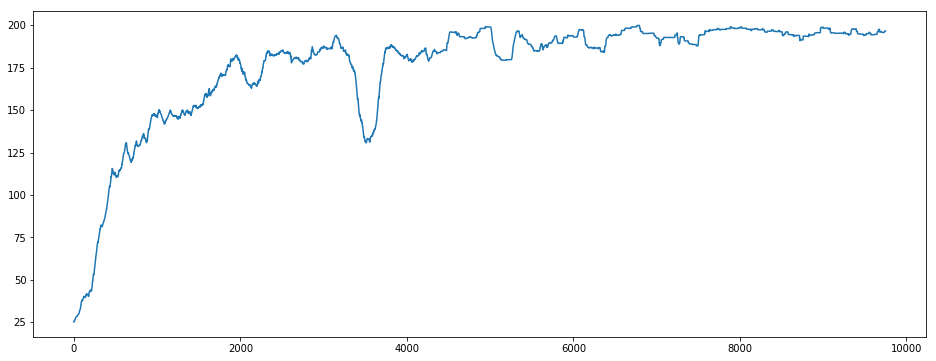

Game OVER


In [10]:
if __name__ == "__main__":
    random.seed(13)
    cartpole = CartPole(episodes=10000)
    scores = cartpole.run()
    scores = moving_average(scores, 250)
    plt.figure(figsize=(16,6))
    plt.plot(scores)
    plt.show()
    print("Game OVER")